# Nonlinear and Conic Optimization

In this part of the session, we discuss methods for modelling and solving conic optimization problems of the form

\begin{align}
\min \ \langle c, x\rangle\\
\text{s.t.} \ A x=b,\\
x \in \mathcal{K},
\end{align}
where $\mathcal{K}$ is a convex cone. 

This optimization problem is actually very general: it models linear, convex quadratic, semidefinite and exponential optimization problems among others. The main advantage of writing problems in this form is that we can solve conic optimization problems very fast using interior point methods.

We will illustrate this idea by solving three important non-linear optimization problems in this part of the class:


- Support vector machine optimization problems (illustrates convex quadratic optimization and second order cones)
- Binary quadratic optimization (illustrates basic semidefinite optimization)
- Matrix completion (illustrates advanced semidefinite and non-convex optimization).

We won't dive into the theory of conic optimization here (there's enough theory to fill up several classes!), but great resources on conic optimization include:
* Convex optimization: https://web.stanford.edu/~boyd/cvxbook/. Very readable.
* Lectures on modern convex optimization: https://www2.isye.gatech.edu/~nemirovs/Lect_ModConvOpt.pdf. Comprehensive, but can go off the deep end.
* The Mosek modelling cookbook: Very readable and compact https://docs.mosek.com/MOSEKModelingCookbook-letter.pdf.

# Background: Different types of conic constraints

We now briefly detail the different types of conic constraints which you might want to use in JuMP. To do so, we will need to load the JuMP.jl package.

In [1]:
using JuMP

## Linear constraints

In [2]:
model = Model()
@variable(model, 0 <= x <= 2)
@variable(model, 0 <= y <= 30)
@constraint(model, 1x + 5y <= 3.0)
@show model

model = A JuMP Model
Feasibility problem with:
Variables: 2
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 2 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 2 constraints
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: x, y


A JuMP Model
Feasibility problem with:
Variables: 2
`GenericAffExpr{Float64,VariableRef}`-in-`MathOptInterface.LessThan{Float64}`: 1 constraint
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 2 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 2 constraints
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: x, y

## Second order cone constraints

In [3]:
A = [1.0 2.0; 3.0 4.0]
u = [2.0, 3.0]
model = Model()
@variable(model, x[1:2])
@variable(model, t)
@constraint(model, [t;A*x+u] in SecondOrderCone())
@show model

model = A JuMP Model
Feasibility problem with:
Variables: 3
`Array{GenericAffExpr{Float64,VariableRef},1}`-in-`MathOptInterface.SecondOrderCone`: 1 constraint
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: t, x


A JuMP Model
Feasibility problem with:
Variables: 3
`Array{GenericAffExpr{Float64,VariableRef},1}`-in-`MathOptInterface.SecondOrderCone`: 1 constraint
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: t, x

## Semidefinite constraints

In [4]:
model = Model()  
@variable(model, y[1:2,1:2], Symmetric)
@constraint(model, y in PSDCone())  
@variable(model, t)
@variable(model, w)
@SDconstraint(model,  [t 1; 1 -w] ⪰ [1 t; t -2])
@show model

model = A JuMP Model
Feasibility problem with:
Variables: 5
`Array{VariableRef,1}`-in-`MathOptInterface.PositiveSemidefiniteConeTriangle`: 1 constraint
`Array{GenericAffExpr{Float64,VariableRef},1}`-in-`MathOptInterface.PositiveSemidefiniteConeSquare`: 1 constraint
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: t, w, y


A JuMP Model
Feasibility problem with:
Variables: 5
`Array{VariableRef,1}`-in-`MathOptInterface.PositiveSemidefiniteConeTriangle`: 1 constraint
`Array{GenericAffExpr{Float64,VariableRef},1}`-in-`MathOptInterface.PositiveSemidefiniteConeSquare`: 1 constraint
Model mode: AUTOMATIC
CachingOptimizer state: NO_OPTIMIZER
Solver name: No optimizer attached.
Names registered in the model: t, w, y

# Support Vector Machine Optimization using Mosek.

Let's make things a bit more concrete by adopting a running example, namely Support Vector Machine optimization using Mosek and JuMP.

Support Vector Machines are a popular model in machine learning for classification. The basic problem is that we are given a set of N points $x_1,x_2,\ldots, x_N \in \mathbb{R}^n$ and labels $y_1, y_2, \ldots, y_n \in \{-1,+1\}$. And we want to find a hyperplane of the form $w^Tx-b = 0$ that separates the two classes, i.e. $w^Tx_i - b \geq 1$ when $y_i = +1$ and $w^Tx_i - b \leq -1$ when $y_i = -1$. This condition can be written as $y_i(w^Tx_i - b) \geq 1, \forall\, i$.

Such a hyperplane will not exist in general if the data overlap, so instead we'll just try to minimize violations of the constraint $y_i(w^Tx_i - b) \geq 1, \forall\, i$ by adding a penalty when it is violated. The optimization problem can be stated as $$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2^2
$$ Note that we penalize the norm of $w$ in order to guarantee a unique solution.

We are going to build our own custom svm solver, so that we can include constraints which off-the-shelf SVM solvers can't handle. Because we are using JuMP, we should expect that our solver will be slower but more flexible than state-of-the-art SVM solvers such as scikit-learn.

Note that while this problem has a quadratic term in the objective, JuMP will actually convert it to a conic quadratic objective automatically!

Let's load the packages we will use to write our custom SVM solver, and define a function which generates some random test data in 2d.

In [5]:
using Mosek, MosekTools, Distributions, Plots, LinearAlgebra, Suppressor, Test
gr(); # In my view, gr is the nicest plotting backend for generating plots in Julia; 
      # I usually use it for generating plots for research papers.

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1273


In [6]:
function gen_data(N)
    # for +1 data, symmetric multivariate normal with center at (1,2)
    pos = rand(MvNormal([1.0,2.0],1.0),N)
    # for -1 data, symmetric multivariate normal with center at (-1,1)
    neg = rand(MvNormal([-1.0,1.0],1.0),N)
    x = [pos neg]
    y = [fill(+1,N);fill(-1,N)]
    return x,y
end

gen_data (generic function with 1 method)

Let's visualize our synthetic data.

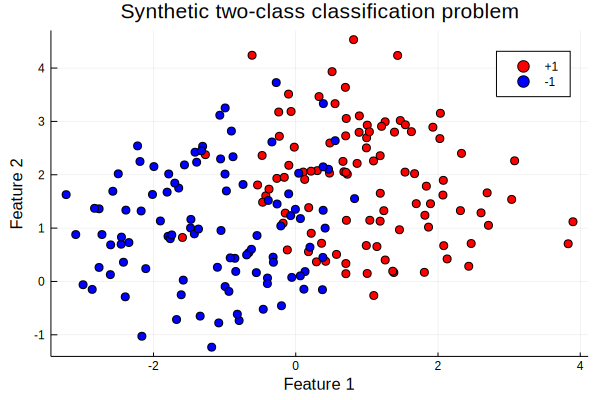

In [7]:
x,y = gen_data(100)
scatter(x[1,1:100], x[2,1:100], c=:red, label="+1", xlabel="Feature 1", ylabel="Feature 2", title="Synthetic two-class classification problem")
scatter!(x[1,101:200], x[2,101:200], c=:blue, label="-1")

In [12]:
γ = 0.005
function svm(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    
    svmModel=Model(with_optimizer(Mosek.Optimizer)) 
    @variable(svmModel, w[1:n])
    @variable(svmModel, b)
    @variable(svmModel, z[1:N]>=0)

    #########################################################
    # You need to fill this bit in.
    @constraint(svmModel,z.>=ones(N)-y.*(x'*w.-b))
    @objective(svmModel, Min, γ*w'*w+sum(z))
    #########################################################
    
    @suppress optimize!(svmModel)
    return value.(w), value.(b)
end

svm (generic function with 1 method)

In [13]:
N = 500
x,y = gen_data(N)

@time w,b = svm(x,y)

 17.857076 seconds (58.11 M allocations: 2.883 GiB, 7.52% gc time)


([1.4337646994117148, 0.7691622856189767], 1.0888023651785848)

Let's visualize this SVM.

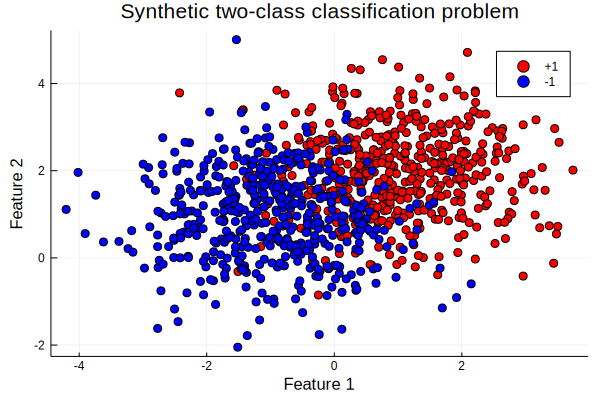

In [14]:
scatter(x[1,1:N], x[2,1:N], c=:red, label="+1", xlabel="Feature 1", ylabel="Feature 2", title="Synthetic two-class classification problem")
scatter!(x[1,(N+1):2*N], x[2,(N+1):2*N], c=:blue, label="-1")


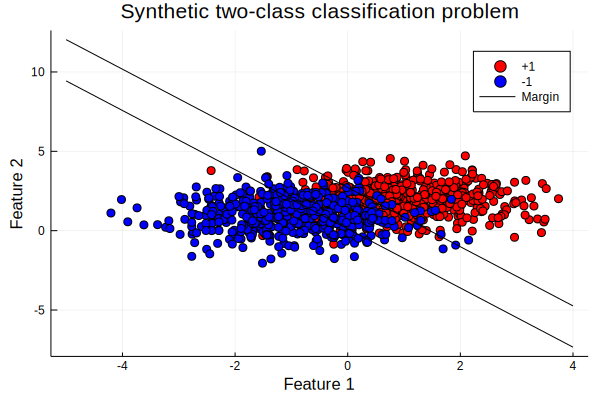

In [15]:
xmin, xmax = [-5,4]
ymin, ymax = [-2,6]
y1 = (1+b-w[1]*xmin)/w[2]
y2 = (1+b-w[1]*xmax)/w[2]
scatter(x[1,1:N], x[2,1:N], c=:red, label="+1", xlabel="Feature 1", ylabel="Feature 2", title="Synthetic two-class classification problem")
scatter!(x[1,(N+1):2*N], x[2,(N+1):2*N], c=:blue, label="-1")
plot!([xmin,xmax], [y1,y2], c=:black, label="Margin")
y1 = (-1+b-w[1]*xmin)/w[2]
y2 = (-1+b-w[1]*xmax)/w[2]
plot!([xmin,xmax], [y1,y2], c=:black, label="")

Some extensions:

- Try adding an $l_1$ regularization term. What happens to the plot? What happens to the solution times?
- Try changing the solver to CPLEX and adding an $l_0$ regularization term. What happens to the plot/solution times?
- These extensions were explored in last year's version of the course, so please see https://github.com/adelarue/cos_2019/blob/master/7_advanced_jump/2-Nonlinear-Programming-Complete.ipynb if you are curious.

# Binary Quadratic Optimization

One of the most famous and frequently studied combinatorial optimization problems is the binary quadratic optimization problem. Given a positive semidefinite matrix $Q$, the objective is to select the vector $x \in \{-1, 1\}^n$ which minimizes $x^\top Q x$. This problem arises in quantum mechanics, computer vision, statistical inference and as the master problem in certain approaches to sparse linear regression, among others. However, despite its importance, it can't be solved to global optimality when $n>250$ with current technology (see the paper "Solving Max-Cut to optimality by intersecting semidefinite and polyhedral relaxations"https://link.springer.com/content/pdf/10.1007/s10107-008-0235-8.pdf for a survey of state-of-the-art methods).

In a spectacular result, Goemans and Williamson (and later Nesterov) demonstrated that by taking a semidefinite relaxation of the binary quadratic problem and randomly rounding it, we can obtain solutions to the max-cut problem which are provably near-optimal in theory and near-exact in practice. Specifically,
\begin{align}
    2/\pi f_{\text{random rounding}} \leq f_{\text{sdp relaxation}} \leq f^* \leq f_{\text{random rounding}},
\end{align}
where

- $f_{\text{random rounding}}$ is the value of any random rounding.
- $f_{\text{sdp relaxation}}$ is the objective value of the SDP relaxation.
- $f^*$ is the optimal value of the problem.



Since Mosek 9.0 can solve SDP relaxations of binary quadratic problems where $n =1000s$, this offers a more scalable method for solving the max-cut problem than integer optimization.

The SDP relaxation is 
\begin{align*}
    \min_{X} \ \langle Q, X \rangle\ \text{s.t.} \ Diag(X)=e,\ X \succeq 0.
\end{align*}

And we randomly round this relaxation by letting $X=V^\top V$ be a Cholesky decomposition of $X$, letting $p$ be a random vector uniformly distributed on the unit sphere, and letting $x_i=sign(p^\top v_i)$.

Let us now write functions to solve the SDP relaxation and perform random rounding.

In [16]:
using Mosek, MosekTools, JuMP
function solveSDPRelaxation(Q::Matrix)
    n=size(Q,1)
    m=Model(with_optimizer(Mosek.Optimizer))
    @variable(m, X[1:n, 1:n], PSD)
    @objective(m, Min, dot(Q,X))
    @constraint(m, diag(X).==1)
    
    @suppress optimize!(m)
    @show objective_value(m)
    opt_X = Hermitian(JuMP.value.(X), :U)  # Tell Julia its PSD.
    factorization = cholesky(opt_X, Val(true); check = false)
    V = (factorization.P * factorization.L)'
    # Normalize columns.
    for i in 1:n
        V[:, i] ./= norm(V[:, i])
    end
    return V
end

solveSDPRelaxation (generic function with 1 method)

In [23]:
using Random
function performRandomRounding(V, Q, numRoundings)
    n=size(Q,1)
    x_best=ones(n)
    ofv_best=1e10
    
    for t=1:numRoundings
        p = rand(n)
        p /= norm(p)
        theX=ones(n)
        for i=1:n
            if dot(p, V[:,i])<=0.0
               theX[i]=-1.0
            end
        end
        if theX'*Q*theX < ofv_best
            x_best=theX
            ofv_best=theX'*Q*theX
        end
    end
    
    return x_best
end

performRandomRounding (generic function with 1 method)

Let's test that our code is working correctly, by solving some small instances and verifying that by randomly rounding we obtain the optimal solution to the BQP. We are testing that our code is correct using the test package. A great way to quickly check that your code is still correct after you changed it is to run a script with an @testset block in it, containing some small problems.

In [24]:
@testset  "Small BQP tests" begin

n=2
weights=[0.0 5.0; 5.0 0.0]
laplacian = diagm(0 => weights * ones(n)) - weights
V=solveSDPRelaxation(-laplacian)
cut=performRandomRounding(V, -laplacian, 100)
@show @test cut[1] != cut[2]

n=4 
W = [0.0 5.0 7.0 6.0;
     5.0 0.0 0.0 1.0;
     7.0 0.0 0.0 1.0;
     6.0 1.0 1.0 0.0]
laplacian = diagm(0 => W * ones(n)) - W
V = solveSDPRelaxation(-laplacian)
cut=performRandomRounding(V, -laplacian, 100)
@test cut[1] != cut[2]
@test cut[2] == cut[3] == cut[4]

n=4
W = [0.0 1.0 5.0 0.0;
         1.0 0.0 0.0 9.0;
         5.0 0.0 0.0 2.0;
         0.0 9.0 2.0 0.0]
laplacian = diagm(0 => W * ones(n)) - W
V = solveSDPRelaxation(-laplacian)
cut=performRandomRounding(V, -laplacian, 100)
    @test cut[1] == cut[4]
    @test cut[2] == cut[3]
    @test cut[1] != cut[2]
end

objective_value(m) = -19.999999999400632
#= In[24]:8 =# @test(cut[1] != cut[2]) = Test Passed
objective_value(m) = -71.99999998992746
objective_value(m) = -67.99999997031453
Test Summary:   | Pass  Total
Small BQP tests |    6      6


Test.DefaultTestSet("Small BQP tests", Any[], 6, false)

Let's now see how well random rounding performs on some larger scale problems, where n=1000.

In [25]:
using DelimitedFiles
BQPData=readdlm("bqp1000")
start=2
n=BQPData[start,1];
Q=zeros(n,n);
nRows=BQPData[start,2]
for i=(start+1):(start+nRows)
   Q[BQPData[i,1],BQPData[i,2]] =BQPData[i,3]
   Q[BQPData[i,2],BQPData[i,1]] =BQPData[i,3] # Make it symmetric
end

In [26]:
V=solveSDPRelaxation(-Q); #negative as we set up to minimize, not maximize

objective_value(m) = -1.070874426293185e6


In [27]:
sdp_bound=1.0708744262931067e6 #multiply by -1 to rearrange to maximize.

1.0708744262931067e6

In [28]:
x_rr=performRandomRounding(V, -Q, 1000);

In [29]:
incumbent=x_rr'*Q*x_rr

762136.0

In [30]:
bound_gap=(sdp_bound-incumbent)/sdp_bound*100

28.830497648713354

We have obtained a randomly rounded solution x which is probably within 28.8% of optimality for this problem in less than 30 seconds, even though the problem size is four times larger than mixed-integer solvers such as CPLEX/Gurobi can solve at all. This is incredible!

Let's visualize the distribution of randomly rounded solutions.

In [31]:
using Random
function getRandomRoundingDist(V, Q, numRoundings)
    n=size(Q,1)
    x_best=ones(n)
    ofv_best=1e10
    dist=zeros(numRoundings)
    
    for t=1:numRoundings
        p = rand(n)
        p /= norm(p)
        theX=ones(n)
        for i=1:n
            if dot(p, V[:,i])<=0.0
               theX[i]=-1.0
            end
        end
        dist[t]=theX'*Q*theX
        if theX'*Q*theX < ofv_best
            x_best=theX
            ofv_best=theX'*Q*theX
        end
    end
    
    return x_best, dist
end

getRandomRoundingDist (generic function with 1 method)

In [32]:
x_rr, dist=getRandomRoundingDist(V, -Q, 1000);

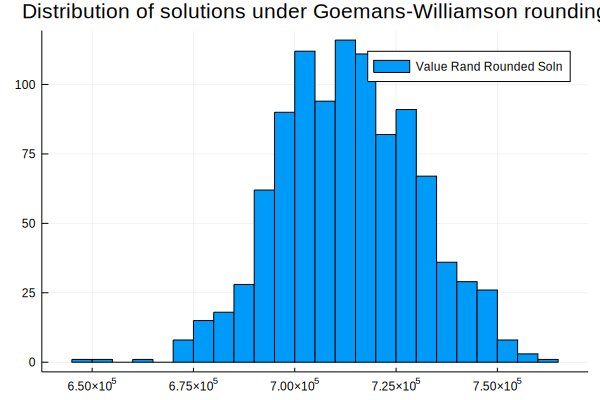

In [33]:
using Plots
gr()
histogram(-dist, label="Value Rand Rounded Soln", title="Distribution of solutions under Goemans-Williamson rounding")

Let's see how SDP scales for an even larger max-cut problem.

In [34]:
using DelimitedFiles
BQPData=readdlm("bqp2500.txt")
start=2
n=BQPData[start,1];
Q=zeros(n,n);
nRows=BQPData[start,2]
for i=(start+1):(start+nRows)
   Q[BQPData[i,1],BQPData[i,2]] =BQPData[i,3]
   Q[BQPData[i,2],BQPData[i,1]] =BQPData[i,3] # Make it symmetric
end

In [35]:
@time V=solveSDPRelaxation(-Q); 

objective_value(m) = -4.357604903624871e6
207.760009 seconds (122.09 M allocations: 4.719 GiB, 2.03% gc time)


The punchline: most people (including some Faculty at MIT!) say that SDP is totally intractable when $n \geq 300$. However, we have just shown that we can optimize over $2500 \times 2500$ matrices in minutes using a standard labtop. Admitedly this example is slightly cherry-picked (if we add too many constraints then SDP can become intractable at a smaller scale than this), but nonetheless SDP is actually often a viable approach.

# Extensions:

- (Challenging) We can often improve the bound gap between the randomly rounded solution and the SDP relaxation substantially (i.e. to near $0$) by adding the triangle inequalites. However, there are $O(n^3)$ triangle inequalities, so we should only add the most violated inequalites to avoid increasing solve times substantially. One very interesting extension would be to integrate the above SDP into a cutting-plane method which does this, and investigate the improvement in (1) bound quality and (2) solution quality (if we randomly round the solution to the SDP relaxation with cuts instead). 
- (Very challenging) We can often beat the Goemans-Williamson bound by taking an appropriate level of the sum-of-squares relaxation heirachy. However, sum-of-squares relaxations are typically even less tractable than semidefinite relaxations. Is it possible to use ideas from sum-of-squares optimization to improve Goemans-Williamson rounding in practice? (it seems unlikely that we can also improve it in theory, for the reasons previously discussed).


# Nuclear norm minimization for matrix completion

One of the most important problems in machine learning is the matrix completion problem. Given a sample $I \subseteq [n] \times [p]$ of entries $A_{(i,j)}: (i,j) \in I$ of a matrix $A$, the objective is to recover the entire matrix, by assuming that it is low rank. A popular strategy for recovering the matrix is to use its nuclear norm as a surrogate for its rank, which leads to the optimization problem
\begin{align}
\min \ \Vert X \Vert_* \ \text{s.t.} \ X_{i,j} = A_{i,j}, \ \forall (i,j) \in I,
\end{align}
where $\Vert X \Vert_*$ is the nuclear norm of $X$, or the sum of the singular values of $X$. We could also inject noise into our observed entries of $A$, but we will refrain from doing this here for simplicity.

In this part of the session, we are going to investigate the performance of the nuclear norm approach on some synthetic matrix completion problems.

We first need to know how to formulate a nuclear norm objective. By a result of Fazel et. al. (2002) (see also Recht et. al. (2010)), it turns out that we can model a nuclear norm objective using semidefinite optimization. Specifically,
\begin{align}
\Vert X \Vert_* \leq t \ \iff \ \begin{pmatrix} U & X\\ X^\top & V \end{pmatrix} \succeq 0, tr(U)+tr(V) \leq 2t
\end{align}

Therefore, we can reformulate a nuclear norm matrix completion problem as the semidefinite optimization problem:
\begin{align}
    \min \frac{1}{2}\left(tr(U)+tr(V)\right) \ \text{s.t.} \ X_{i,j} = A_{i,j}, \ \forall (i,j) \in I, \begin{pmatrix} U & X\\ X^\top & V \end{pmatrix} \succeq 0.
\end{align}

Let's investigate how well this approach performs at recovering synthetic matrices, and how well it scales.
We use the following notation:

- n: dimension of the matrix.
- p: proportion of entries sampled.
- r: rank of the underlying matrix.

We're going to generate rank-r matrices $M \in \mathbb{R}^{n \times n}$ by generating two matrices $M_L, M_R \in \mathbb{R}^{n \times r}$ with i.i.d. $\mathcal{N}(0,1)$ entries, and setting $M=M_L M_R^\top$. By varying the proportion of the entries of $M$ which we observe, we will see how much data we need to observe to recover the entire matrix.

Let's define the SDP solver and the random instance generator.

In [12]:
function getMatrixNuclearNorm(coords, entries, M)
    n=size(M, 1)
    numEntries=size(entries,1)
    m=Model(with_optimizer(Mosek.Optimizer))
    @variable(m, X[1:n, 1:n])
    @variable(m, U[1:n, 1:n])
    @variable(m, V[1:n, 1:n])

     for t=1:Int(numEntries)
         @constraint(m, X[coords[entries[t],1], coords[entries[t],2]]==M[coords[entries[t],1], coords[entries[t],2]])
     end
    # We would need to multiply all terms in the objective by 0.5 to match the objective function; we have scaled this out for simplicity.
    @objective(m, Min, sum(U[i,i] for i=1:n)+sum(V[i,i] for i=1:n))
    @constraint(m, Symmetric([U X; X' V]) in PSDCone());
    @suppress optimize!(m)
    error=norm(value.(X)-M)/norm(M)
   return error
end

getMatrixNuclearNorm (generic function with 1 method)

In [13]:
using Random
function generateRandomMatrixInstance(n, r, p)
   numEntries=p*n^2
   M_L=randn(n, r)
   M_R=randn(n, r)
   M=M_L*M_R'
   coords=[repeat(1:n, inner=size(1:n,1)) repeat(1:n, outer=size(1:n,1))];
   entries=sample(1:n^2, Int(numEntries), replace=false)
  return M, coords, entries
end

generateRandomMatrixInstance (generic function with 1 method)

Let's investigate how much data we need to recover a rank-5 matrix when n=100 (I ran this bit offline). Let's also compare the method with the very popular Burer-Monterio heuristic (see http://www.optimization-online.org/DB_FILE/2001/03/296.pdf), under the (drastic) assumption that we know that the underlying matrix is rank-5. Note that we need to minimize the sum of squared error and use a random initial point for the Burer-Monterio heuristic, since it will return a matrix of all zeros otherwise.

In [14]:
using Ipopt

In [15]:
function getMatrixBM(coords, entries, M, r=5)
    n=size(M, 1)
    numEntries=size(entries,1)
    m=Model(with_optimizer(Ipopt.Optimizer))
    @variable(m, X[1:n, 1:n])
    @variable(m, U[1:n, 1:r])
    @variable(m, V[1:r, 1:n])
    gamma=1e6 #impose some regularization to accelerate convergence.
    
    U_init=randn(n,r) # initialize randomly at zero.
    V_init=randn(r,n)
    JuMP.set_start_value.(U, U_init)
    JuMP.set_start_value.(V, V_init)

    @objective(m, Min, 1.0/(2.0*gamma)*sum(X[i,j]^2 for i=1:n for j=1:n)+sum((X[coords[entries[t],1], coords[entries[t],2]]-M[coords[entries[t],1], coords[entries[t],2]])^2 for t in 1:Int(numEntries)))
    @constraint(m, X.==U*V);
    optimize!(m)
    error=norm(value.(X)-M)/norm(M)
   return error
end

getMatrixBM (generic function with 2 methods)

In [18]:
r=5;
n=100;
numExperiments=5
errors_nn=zeros(16)
errors_bm=zeros(16)
for p in 0.05:0.05:0.8
   for t in 1:numExperiments
        M, coords, entries=generateRandomMatrixInstance(n, r, p)
        @show error_nn=getMatrixNuclearNorm(coords, entries, M)
        errors_nn[Int(p*20)]+=error_nn/numExperiments
        @show error_bm=getMatrixBM(coords, entries, M)
        errors_bm[Int(p*20)]+=error_bm/numExperiments
   end
end
    

error_nn = getMatrixNuclearNorm(coords, entries, M) = 0.9775792797640832
error_bm = getMatrixBM(coords, entries, M) = 1.0488248562494176
error_nn = getMatrixNuclearNorm(coords, entries, M) = 0.9844169115251652
error_bm = getMatrixBM(coords, entries, M) = 1.0712905658993372
error_nn = getMatrixNuclearNorm(coords, entries, M) = 0.9561452860752562
error_bm = getMatrixBM(coords, entries, M) = 0.9811205580626206
error_nn = getMatrixNuclearNorm(coords, entries, M) = 0.9985385854297032
error_bm = getMatrixBM(coords, entries, M) = 1.096648847287094
error_nn = getMatrixNuclearNorm(coords, entries, M) = 0.9560465132420048
error_bm = getMatrixBM(coords, entries, M) = 1.066116170768041
error_nn = getMatrixNuclearNorm(coords, entries, M) = 0.7473658578841983
error_bm = getMatrixBM(coords, entries, M) = 3.2224508690750158
error_nn = getMatrixNuclearNorm(coords, entries, M) = 0.718887696066894
error_bm = getMatrixBM(coords, entries, M) = 3.309305389482214
error_nn = getMatrixNuclearNorm(coords, entri

error_bm = getMatrixBM(coords, entries, M) = 1.0192206420992003e-6
error_nn = getMatrixNuclearNorm(coords, entries, M) = 1.1275154460004712e-9
error_bm = getMatrixBM(coords, entries, M) = 9.904845356582522e-7
error_nn = getMatrixNuclearNorm(coords, entries, M) = 4.630427522793417e-10
error_bm = getMatrixBM(coords, entries, M) = 9.044385939440367e-7
error_nn = getMatrixNuclearNorm(coords, entries, M) = 3.3709168688801472e-12
error_bm = getMatrixBM(coords, entries, M) = 9.148737496195809e-7
error_nn = getMatrixNuclearNorm(coords, entries, M) = 1.1151932614745604e-10
error_bm = getMatrixBM(coords, entries, M) = 8.972024588414652e-7
error_nn = getMatrixNuclearNorm(coords, entries, M) = 1.4711940114112377e-10
error_bm = getMatrixBM(coords, entries, M) = 8.602305070517463e-7
error_nn = getMatrixNuclearNorm(coords, entries, M) = 1.5230472756829433e-10
error_bm = getMatrixBM(coords, entries, M) = 8.774409167823004e-7
error_nn = getMatrixNuclearNorm(coords, entries, M) = 9.116022232761341e-9
er

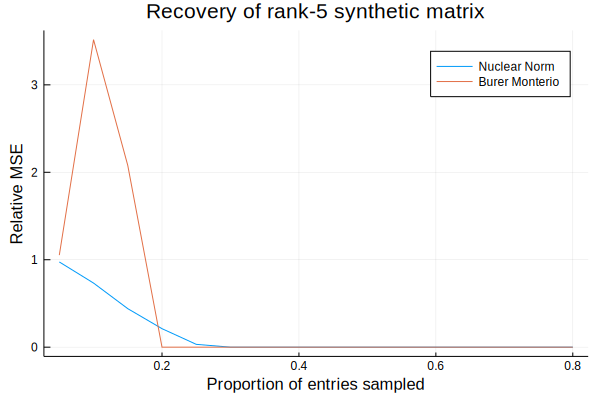

In [19]:
using Plots
gr()
plot(0.05:0.05:0.8, errors_nn, xlabel="Proportion of entries sampled", ylabel="Relative MSE", title="Recovery of rank-5 synthetic matrix", label="Nuclear Norm")
plot!(0.05:0.05:0.8, errors_bm, label="Burer Monterio")

Observe that initially using a nuclear norm penalty is better than a non-linear factorization, but as we observe more data the Burer-Monterio approach undergoes a phase transition and recovers the exact matrix, while the nuclear norm approach requires more data to recover the true matrix. 

More to the point, we have sucessfully compared two state of the art methods using fewer than 200 lines of JuMP code; without JuMP this would probably take a week or longer to do.